<a href="https://colab.research.google.com/github/reitezuz/18NES2-2025/blob/main/week_06/CIFAR10_load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Subset – Data preparation and visualization


## Description

This notebook demonstrates how to:
- Load and preprocess a subset of the CIFAR-10 dataset (with selected classes).
- Create balanced training, validation, and test splits using NumPy.
- Build TensorFlow data loaders compatible with previous CNN notebooks (e.g., Cats vs Dogs).
- Visualize example images and inspect model predictions (correct and misclassified).

In [2]:
# Load the data:

# CIFAR-10 label names for reference
import numpy as np
import tensorflow as tf

cifar10_names = np.array([
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
])

# --- load raw CIFAR-10 ---
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.cifar10.load_data()
y_train_raw = y_train_raw.reshape(-1)
y_test_raw  = y_test_raw.reshape(-1)



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
# Config
selected_classes = [0, 1, 2, 7]     # e.g. airplane, automobile, bird, horse
per_class_train = 500               # 4 classes → 4*500 = 2000 train
per_class_val   = 250               # 4*250 = 1000 val
per_class_test  = 250               # 4*250 = 1000 test
batch_size = 64
image_size = (180, 180)             # set to (180,180) to match Cats&Dogs models

seed = 42
rng = np.random.default_rng(seed)

In [5]:
# Selection of the subsets:

# --- Helper: simple per-class selection ---
def select_subset(x, y, classes, n_per_class):
    idx = []
    for c in classes:
        ids = np.where(y == c)[0]
        rng.shuffle(ids)
        idx.extend(ids[:n_per_class])
    idx = np.array(idx)
    rng.shuffle(idx)
    return x[idx], y[idx]

# --- Select subsets ---
x_train_sel, y_train_sel = select_subset(x_train_raw, y_train_raw, selected_classes, per_class_train + per_class_val)
x_test,  y_test  = select_subset(x_test_raw,  y_test_raw,  selected_classes, per_class_test)

# --- Split train/val ---
n_train = len(selected_classes) * per_class_train
x_train, x_val = x_train_sel[:n_train], x_train_sel[n_train:]
y_train, y_val = y_train_sel[:n_train], y_train_sel[n_train:]

# --- Remap labels to 0..C-1 ---
class_map = {c: i for i, c in enumerate(selected_classes)}
y_train = np.vectorize(class_map.get)(y_train)
y_val   = np.vectorize(class_map.get)(y_val)
y_test  = np.vectorize(class_map.get)(y_test)

class_names = cifar10_names[selected_classes]
print("Classes:", class_names)

for name, data in zip(["train", "val", "test"], [(x_train, y_train), (x_val, y_val), (x_test, y_test)]):
    print(f"{name}: {len(data[0])} samples")



Classes: ['airplane' 'automobile' 'bird' 'horse']
train: 2000 samples
val: 1000 samples
test: 1000 samples


In [6]:
# --- Create tf.data datasets ---
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(x, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    def preprocess(img, label):
        img = tf.image.resize(img, image_size)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(1000, seed=seed)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(x_train, y_train, training=True)
val_ds   = make_dataset(x_val,   y_val,   training=False)
test_ds  = make_dataset(x_test,  y_test,  training=False)

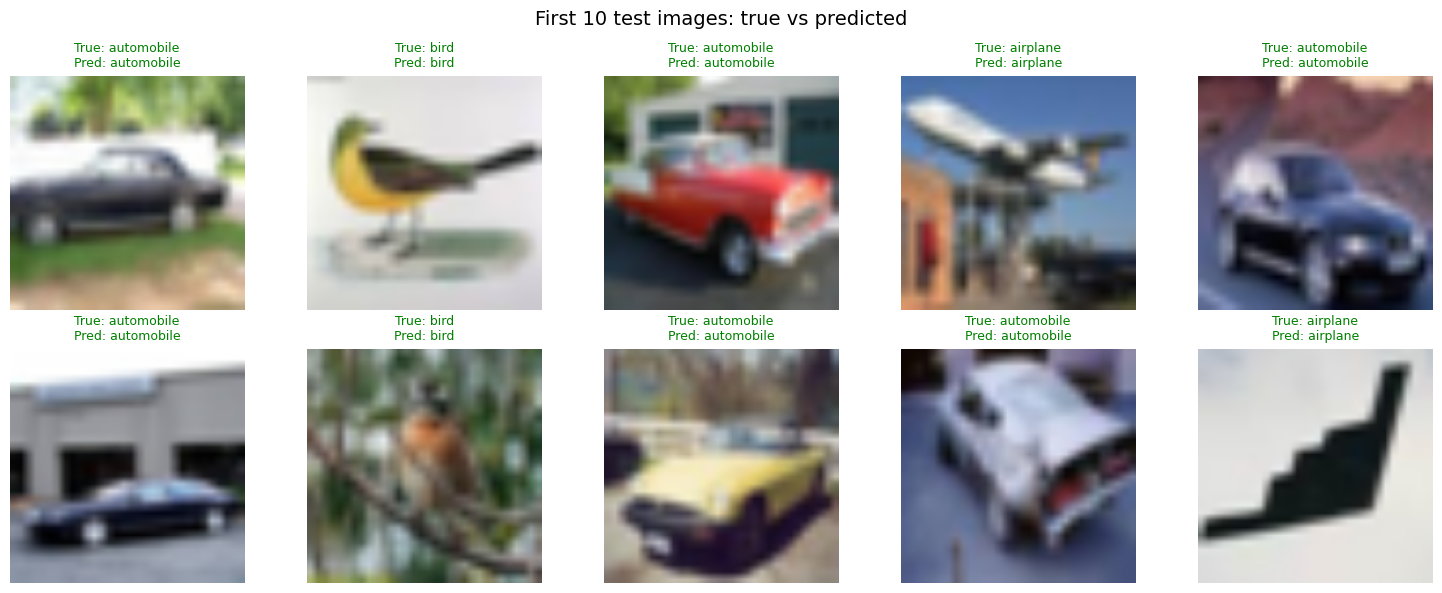

In [8]:
# visualization
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Take first batch from test dataset
test_batch = next(iter(test_ds))
images, labels = test_batch

# Get predictions for that batch
#preds = model.predict(images, verbose=0)
#pred_labels = np.argmax(preds, axis=1)

# Plot first 10 images with predictions
n_show = 10
plt.figure(figsize=(15, 6))
for i in range(n_show):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    true_label = class_names[labels[i]]
    pred_label = true_label
    #pred_label = class_names[pred_labels[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=9)
    plt.axis("off")

plt.suptitle("First 10 test images: true vs predicted", fontsize=14)
plt.tight_layout()
plt.show()
